In [1]:
import nbimporter
import Generalized_Galton_Board # This imports from Generalized_Galton_Board.ipynb
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit.circuit.library import HGate, RYGate, RXGate, XGate
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
import numpy as np
# %matplotlib inline


# Check that the account has been saved properly
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler
from qiskit_aer import AerSimulator
from qiskit.providers.fake_provider import GenericBackendV2
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
from qiskit.transpiler import PassManager, Layout
from qiskit.transpiler.passes import *

## Setting Up Noisy Backend Simulators

This section implements realistic noise models by creating simulators that replicate the error characteristics and physical constraints of actual IBM quantum processors. We analyze how hardware limitations affect the Quantum Galton Board (QGB) algorithm performance compared to the idealized noiseless simulations from `Generalized_Galton_Board.ipynb`.

Real quantum devices impose fundamental constraints that significantly affect algorithm execution:

- **Number of qubits**: Total physical qubits available on the quantum processor
- **Coupling map**: Graph showing which qubits can directly interact (perform two-qubit gates)
- **Readout error**: Probability of measurement errors when reading qubit states
- **Basis gates**: Native gate set that the hardware can execute directly 
- **Gate fidelities**: Imperfect gate operations introducing computational errors

To execute circuits on realistic hardware, we employ Qiskit's **Pass Manager** for automated circuit optimization and hardware mapping (logical to physical qubits):

- **optimization_level=3**: Highest optimization level that performs aggressive circuit simplification, gate reduction, and routing optimization
- **seed_transpiler**: Ensures reproducible results by fixing the randomness in optimization algorithms
- The pass manager handles gate decomposition, qubit mapping, and circuit optimization automatically

This realistic simulation framework enables quantitative analysis of how quantum noise degrades the QGB's statistical properties.

In [2]:
service = QiskitRuntimeService(name= 'general-use') # please save your details first, and change the instance name accordingly
# service.saved_accounts()
seed= 42

real_backends = service.backends()
print(f"The quantum computers available for you are {real_backends}")

real_backends = [
    service.backend("ibm_brisbane"),
    service.backend("ibm_torino"),
]

noisy_fake_backends = []
for backend in real_backends:
    noisy_fake_backends.append(AerSimulator.from_backend(backend, seed_simulator=seed))
print(f"The noisy simulators are {noisy_fake_backends}")

# Taking the ibm_torino as an example
properties = noisy_fake_backends[1].properties()
print(f"Properties of the backend {noisy_fake_backends[1].name}:")
print(f"Number of qubits: {noisy_fake_backends[1].num_qubits}")
print(f"Coupling map: {noisy_fake_backends[1].coupling_map}")
print(f"Readout error: {properties.readout_error(1)}")
print(noisy_fake_backends[1].configuration().basis_gates)

The quantum computers available for you are [<IBMBackend('ibm_brisbane')>, <IBMBackend('ibm_torino')>]
The noisy simulators are [AerSimulator('aer_simulator_from(ibm_brisbane)'
             noise_model=<NoiseModel on ['sx', 'reset', 'x', 'id', 'ecr', 'measure']>), AerSimulator('aer_simulator_from(ibm_torino)'
             noise_model=<NoiseModel on ['cz', 'sx', 'reset', 'x', 'id', 'measure']>)]
Properties of the backend aer_simulator_from(ibm_torino):
Number of qubits: 133
Coupling map: [[0, 1], [0, 15], [1, 0], [1, 2], [2, 1], [2, 3], [3, 2], [3, 4], [4, 3], [4, 5], [4, 16], [5, 4], [5, 6], [6, 5], [6, 7], [7, 6], [7, 8], [8, 7], [8, 9], [8, 17], [9, 8], [9, 10], [10, 9], [10, 11], [11, 10], [11, 12], [12, 11], [12, 13], [12, 18], [13, 12], [13, 14], [14, 13], [15, 0], [15, 19], [16, 4], [16, 23], [17, 8], [17, 27], [18, 12], [18, 31], [19, 15], [19, 20], [20, 19], [20, 21], [21, 20], [21, 22], [21, 34], [22, 21], [22, 23], [23, 16], [23, 22], [23, 24], [24, 23], [24, 25], [25, 24], [

### Useful functions to analyze errors in a transpiled circuit

In [3]:
def circuit_error_analysis(backend, circuit: QuantumCircuit, n: int) -> dict:
    """
    Comprehensive error analysis for a transpiled quantum circuit.
    
    Args:
        backend: Quantum backend with properties
        circuit: Transpiled quantum circuit
        n: Number of levels in Galton board (for readout error calculation)
    
    Returns:
        dict: Complete error analysis including totals, breakdowns, and pair details
    """
    properties = backend.properties()
    
    acc_single_qubit_error = 0
    single_qubit_gate_count = 0
    two_qubit_gate_count = 0
    pair_dict = {}  
    
    basis_gates = backend.configuration().basis_gates
    two_qubit_gate = "ecr" if "ecr" in basis_gates else "cz"
    
    # Process all instructions in one pass
    for instruction in circuit.data:
        num_qubits = instruction.operation.num_qubits
        operation_name = instruction.operation.name
        
        if num_qubits == 1 and operation_name not in ['measure', 'reset']:
            # Single-qubit gate processing
            try:
                qubits = [circuit.qubits.index(q) for q in instruction.qubits]
                acc_single_qubit_error += properties.gate_error(gate=operation_name, qubits=qubits)
                single_qubit_gate_count += 1
            except (ValueError, KeyError):
                # Skip if gate error data not available for this qubit
                single_qubit_gate_count += 1
                
        elif num_qubits == 2:
            # Two-qubit gate processing
            two_qubit_gate_count += 1
            pair = tuple(sorted([instruction.qubits[0]._index, instruction.qubits[1]._index]))
            
            try:
                error = properties.gate_error(gate=two_qubit_gate, qubits=list(pair))
                
                if pair in pair_dict:
                    pair_dict[pair]['accumulated_error'] += error
                    pair_dict[pair]['count'] += 1
                else:
                    pair_dict[pair] = {
                        'single_error': error,
                        'accumulated_error': error,
                        'count': 1
                    }
            except (ValueError, KeyError):
                # Skip if gate error data not available for this qubit pair
                # This can happen when qubits are not connected or error data is missing
                # print(f"Warning: Could not find error data for {two_qubit_gate} gate on qubits {pair}")
                if pair not in pair_dict:
                    pair_dict[pair] = {
                        'single_error': 0.0,
                        'accumulated_error': 0.0,
                        'count': 1
                    }
                else:
                    pair_dict[pair]['count'] += 1
    
    # Calculate readout errors with error handling
    try:
        qubit_layout = list(circuit.layout.initial_layout.get_physical_bits().keys())[:2*n + 1]
        acc_readout_error = 0
        for q in qubit_layout:
            try:
                acc_readout_error += properties.readout_error(q)
            except (ValueError, KeyError):
                # print(f"Warning: Could not find readout error for qubit {q}")
                pass
    except (AttributeError, KeyError):
        # print("Warning: Could not access qubit layout, setting readout error to 0")
        acc_readout_error = 0
    
    # Calculate totals
    acc_two_qubit_error = sum(pair_data['accumulated_error'] for pair_data in pair_dict.values())
    acc_total_error = acc_two_qubit_error + acc_single_qubit_error + acc_readout_error
    
    # Prepare pair analysis data
    pair_list = list(pair_dict.keys())
    error_pair_list = [pair_dict[pair]['single_error'] for pair in pair_list]
    error_acc_pair_list = [pair_dict[pair]['accumulated_error'] for pair in pair_list]
    
    return {
        # Detailed error breakdown
        'errors': {
            'total': acc_total_error,
            'two_qubit': acc_two_qubit_error,
            'single_qubit': acc_single_qubit_error,
            'readout': acc_readout_error
        },
        
        # Gate counts
        'gate_counts': {
            'single_qubit': single_qubit_gate_count,
            'two_qubit': two_qubit_gate_count
        },
        
        # Two-qubit pair analysis
        'pair_analysis': {
            'pairs': pair_list,
            'single_errors': error_pair_list,
            'accumulated_errors': error_acc_pair_list,
            'pair_details': pair_dict
        }
    }

## 3-Level QGB: Noisy Hardware Simulation

As an example we demonstrate a $3$ level QGB on a noisy simulator.

In [4]:
n=3 # number of levels in the Galton board
qc = Generalized_Galton_Board.galton_box_shifted(n, HGate(), draw=False)
backend= AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
qc_transpiled = transpile(qc, backend, optimization_level=3)
qubit_layout = list(qc_transpiled.layout.initial_layout.get_physical_bits().keys())[:2*n +1] 
print(f"Qubit layout: {qubit_layout}")

print('Gates used on the noisy simulator:', qc_transpiled.count_ops()) 

Qubit layout: [29, 28, 30, 36, 27, 31, 17]
Gates used on the noisy simulator: OrderedDict([('sx', 352), ('rz', 250), ('cz', 172), ('x', 5), ('measure', 4), ('reset', 3)])


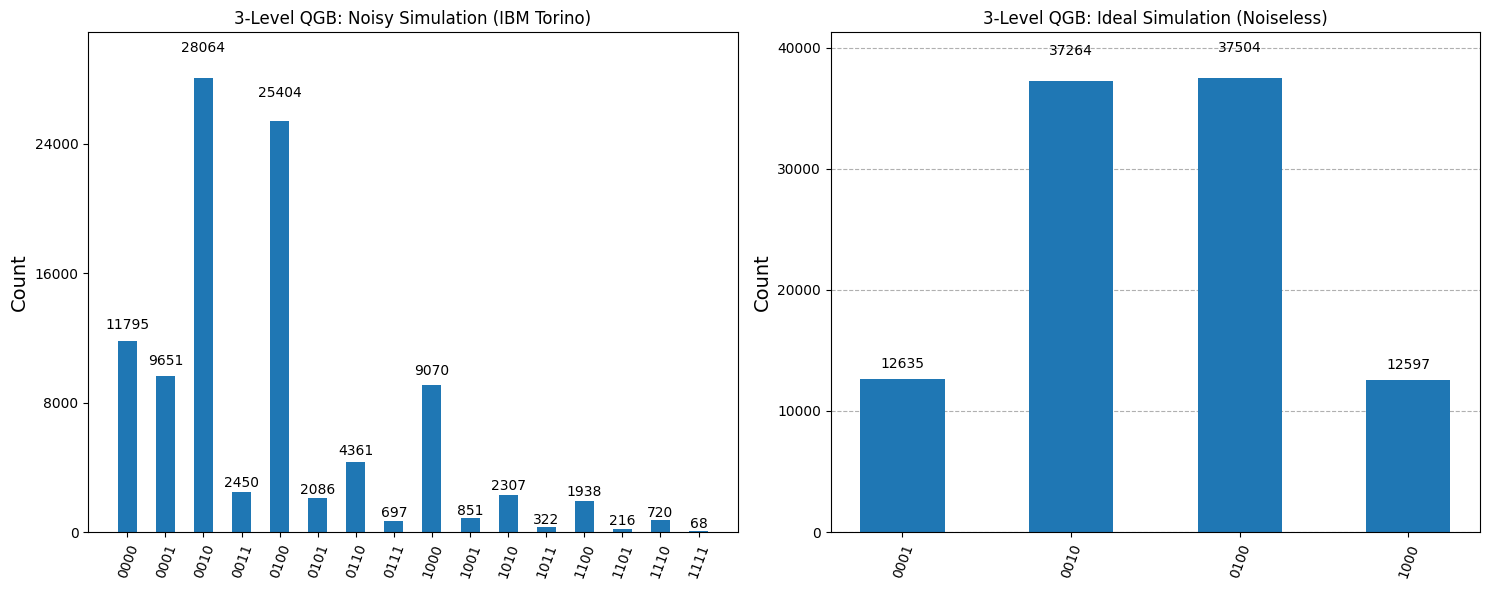

In [ ]:
# Run noisy simulation
job = backend.run(qc_transpiled, shots=100000)  # Using same shot count for fair comparison
noisy_counts = job.result().get_counts()

# Run noiseless simulation
backend_wo_noise = AerSimulator()
compiled = transpile(qc, backend_wo_noise, optimization_level=3)
job = backend_wo_noise.run(compiled, shots=100000)  # Using same shot count for fair comparison
noiseless_counts = job.result().get_counts()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot noisy results
if noisy_counts:
    total_shots = sum(noisy_counts.values())
    probabilities = {state: count/total_shots for state, count in noisy_counts.items()}

    plot_histogram(probabilities)
    plt.ylabel('Probability')
    plt.show()
    ax1.set_title(f"{n}-Level QGB: Noisy Simulation (IBM Torino)", fontsize=12)
    
# Plot noiseless results
if noiseless_counts:
    total_shots = sum(noiseless_counts.values())
    probabilities = {state: count/total_shots for state, count in noiseless_counts.items()}

    plot_histogram(probabilities, ax=ax2)
    ax2.set_title(f"{n}-Level QGB: Ideal Simulation (Noiseless)", fontsize=12)

plt.tight_layout()
plt.show()



#### The noisy simulation results show additional measurement outcomes not present in the ideal case. 

Since the theoretical Quantum Galton Board produces measurement outcomes with exactly one '1' and the remaining bits as '0' (i.e., bitstrings with Hamming weight 1), we can filter out noise-induced erroneous samples by retaining only these valid outcomes.

In [6]:
def filter_counts_by_hamming_weight(counts: dict) -> dict:
    """
    Filters a dictionary of measurement counts, keeping only the outcomes
    that have a Hamming weight of 1.

    Args:
        counts (dict): The dictionary of measurement outcomes and their counts.
                       The keys are binary strings (e.g., '0100').

    Returns:
        dict: A new dictionary with only the filtered counts.
    """
    filtered_counts = {}
    for outcome, count in counts.items():
        if outcome.count('1') == 1:
            filtered_counts[outcome] = count
    return filtered_counts

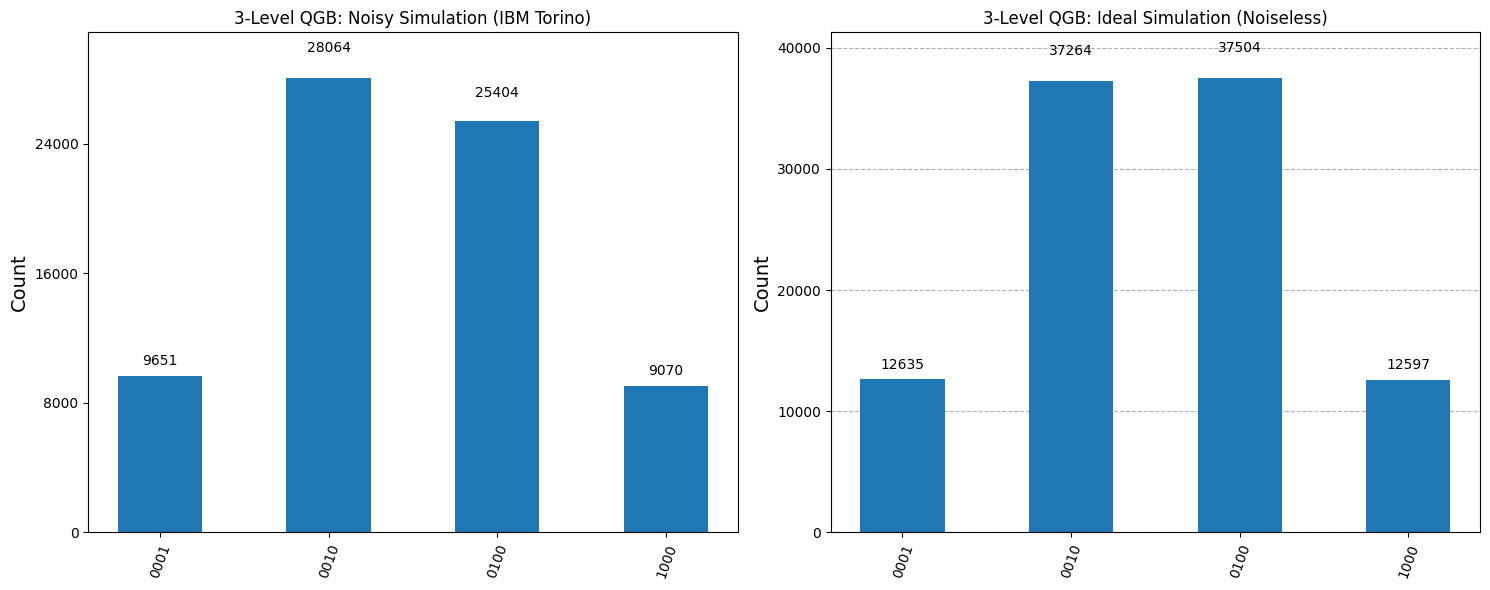

In [ ]:
filtered_noisy_counts = filter_counts_by_hamming_weight(noisy_counts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot post processed noisy results
if filtered_noisy_counts:
    total_shots = sum(filtered_noisy_counts.values())
    probabilities = {state: count/total_shots for state, count in filtered_noisy_counts.items()}
    plot_histogram(probabilities, ax=ax1)
    ax1.set_title(f"{n}-Level QGB: Noisy Simulation (IBM Torino)", fontsize=12)

# Plot noiseless results
if noiseless_counts:
    total_shots = sum(noiseless_counts.values())
    probabilities = {state: count/total_shots for state, count in noiseless_counts.items()}
    plot_histogram(probabilities, ax=ax2)
ax2.set_title(f"{n}-Level QGB: Ideal Simulation (Noiseless)", fontsize=12)

plt.tight_layout()
plt.show()

### Post-Transpilation Error Analysis



In [8]:
gaussian_transpiled_list = []
errors_and_counts_list = []
for noisy_fake_backend in noisy_fake_backends:

    backend= AerSimulator.from_backend(noisy_fake_backend)  # Using the noisy simulator for ibm_torino
    circuit_transpiled = transpile(qc, backend, optimization_level=3)
    qubit_layout = list(circuit_transpiled.layout.initial_layout.get_physical_bits().keys())[:2*n +1] 
    print(f"Qubit layout: {qubit_layout}")

    print('Gates used on the noisy simulator:', circuit_transpiled.count_ops())

    gaussian_transpiled_list.append(circuit_transpiled)

    error_analysis = circuit_error_analysis(noisy_fake_backend, circuit_transpiled, n)
    errors_and_counts = [
        error_analysis['errors']['total'],
        error_analysis['errors']['two_qubit'], 
        error_analysis['errors']['single_qubit'],
        error_analysis['errors']['readout'],
        error_analysis['gate_counts']['single_qubit'],
        error_analysis['gate_counts']['two_qubit']
    ]
    errors_and_counts_list.append(errors_and_counts)


for backend, (
    acc_total_error,
    acc_two_qubit_error,
    acc_single_qubit_error,
    acc_readout_error,
    single_qubit_gate_count,
    two_qubit_gate_count,
) in zip(noisy_fake_backends, errors_and_counts_list):
    print(f"Backend {backend.name}")
    print(f"Accumulated two-qubit error of {two_qubit_gate_count} gates: {acc_two_qubit_error:.3f}")
    print(
        f"Accumulated one-qubit error of {single_qubit_gate_count} gates: {acc_single_qubit_error:.3f}"
    )
    print(f"Accumulated readout error: {acc_readout_error:.3f}")
    print(f"Accumulated total error: {acc_total_error:.3f}\n")

Qubit layout: [60, 59, 53, 41, 58, 42, 43]
Gates used on the noisy simulator: OrderedDict([('rz', 533), ('sx', 321), ('ecr', 180), ('x', 35), ('measure', 4), ('reset', 3)])
Qubit layout: [29, 28, 30, 36, 27, 31, 17]
Gates used on the noisy simulator: OrderedDict([('sx', 352), ('rz', 250), ('cz', 172), ('x', 5), ('measure', 4), ('reset', 3)])
Backend aer_simulator_from(ibm_brisbane)
Accumulated two-qubit error of 180 gates: 0.604
Accumulated one-qubit error of 889 gates: 0.086
Accumulated readout error: 0.106
Accumulated total error: 0.796

Backend aer_simulator_from(ibm_torino)
Accumulated two-qubit error of 172 gates: 0.547
Accumulated one-qubit error of 607 gates: 0.157
Accumulated readout error: 0.125
Accumulated total error: 0.829



#### Backend Comparison: IBM Torino shows superior gate fidelity and it has the least total error. Hence we use this for further optimization. 

#### Let's try to map the logical qubits to physical qubits with a goal of reducing the two qubit gate error.

The function `finding_best_seed` searches through 500 different transpiler seeds using the SABRE layout method to find the optimal qubit mapping that minimizes two-qubit gate errors for a given quantum circuit and backend.

**Note:** SABRE (SWAP-based Bidirectional heuristic for Routing) is an advanced qubit routing algorithm that efficiently maps logical qubits to physical qubits by minimizing the number of SWAP gates needed to satisfy hardware connectivity constraints.

In [9]:
def finding_best_seed(
    circuit: QuantumCircuit, backend, n: int
) -> tuple[QuantumCircuit, int, float, int]:
    """Find the transpiler seed that minimizes two-qubit gate error for a given circuit and backend."""

    # We initialize the minimum error accumulated
    min_err_acc_seed_loop = 100
    circuit_opt_best_seed = None
    best_seed_transpiler = 0
    
    for seed_transpiler in range(0, 500):
        pm = generate_preset_pass_manager(
            backend=backend,
            optimization_level=3,
            seed_transpiler=seed_transpiler,
            layout_method="sabre",  # dense layout gave a higher error than sabre
        )

        circuit_opt_seed = pm.run([circuit])[0]
        
        error_analysis = circuit_error_analysis(backend, circuit_opt_seed, n)
        acc_two_qubit_error_seed_loop = error_analysis['errors']['two_qubit']
        two_qubit_gate_count_seed_loop = error_analysis['gate_counts']['two_qubit']
        
        if acc_two_qubit_error_seed_loop < min_err_acc_seed_loop:
            min_err_acc_seed_loop = acc_two_qubit_error_seed_loop
            circuit_opt_best_seed = circuit_opt_seed
            best_seed_transpiler = seed_transpiler

    return (
        circuit_opt_best_seed,
        best_seed_transpiler,
        min_err_acc_seed_loop,
        two_qubit_gate_count_seed_loop,
    )



(
    circuit_opt_seed_loop,
    best_seed_transpiler,
    min_err_acc_seed_loop,
    two_qubit_gate_count_seed_loop,
) = finding_best_seed(qc, noisy_fake_backends[1], n)  

best_layout = list(circuit_opt_seed_loop.layout.initial_layout.get_physical_bits().keys())[:2*n+1]
print(f"Minimum accumulated two-qubit gate error: {min_err_acc_seed_loop:.3f}")
print(f"Two-qubit gate count for best seed: {two_qubit_gate_count_seed_loop}")
print(f"Best layout (first 2n+1 logical qubits mapped to physical qubits):\n {best_layout}")


error_analysis = circuit_error_analysis(noisy_fake_backends[1], circuit_opt_seed_loop, n)
print(f"Accumulated single-qubit error: {error_analysis['errors']['single_qubit']:.3f}")
print(f"Accumulated readout error: {error_analysis['errors']['readout']:.3f}")
print(f"Accumulated total error: {error_analysis['errors']['total']:.3f}")
print(f"Single-qubit gate count: {error_analysis['gate_counts']['single_qubit']}")

Minimum accumulated two-qubit gate error: 0.320
Two-qubit gate count for best seed: 169
Best layout (first 2n+1 logical qubits mapped to physical qubits):
 [65, 68, 74, 67, 66, 64, 55]
Accumulated single-qubit error: 0.081
Accumulated readout error: 0.150
Accumulated total error: 0.552
Single-qubit gate count: 568


Through optimal logical-to-physical qubit mapping, we achieved a significant reduction in accumulated two-qubit gate error from 41.9% to 32% for the n=3 QGB implementation on IBM Torino. Even the total error slightly decreased to 56% from 64.8%.


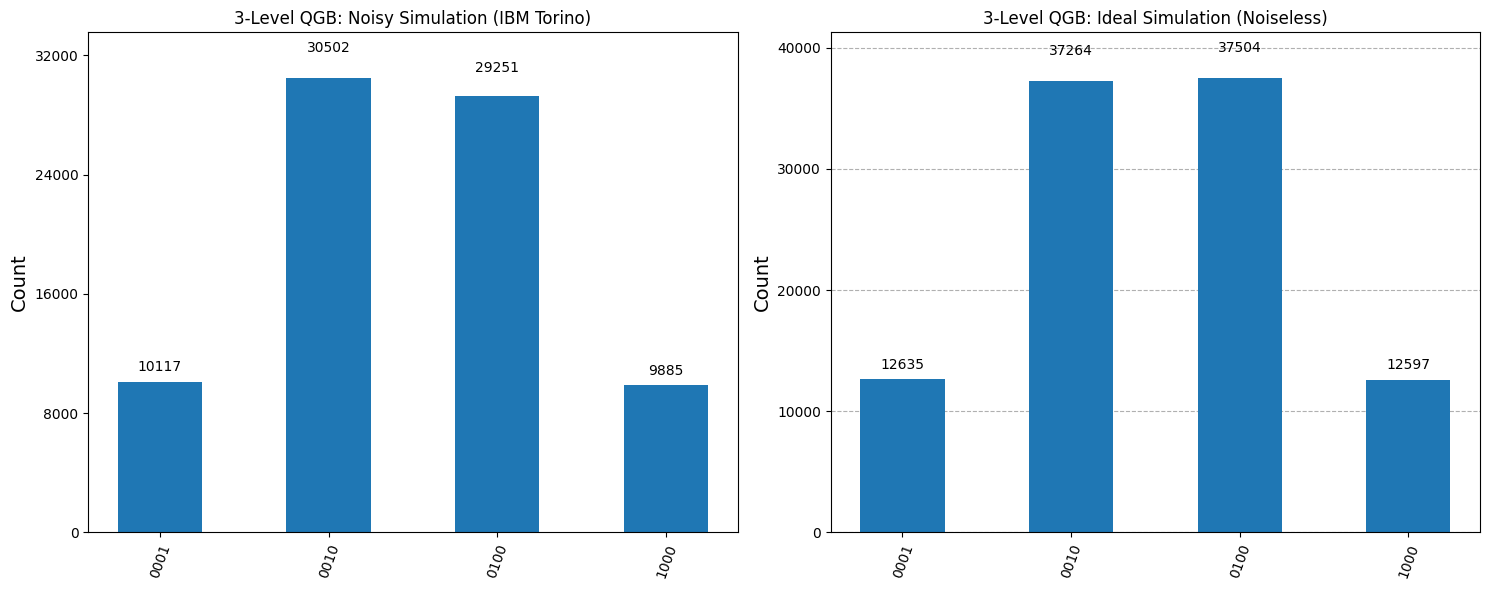

In [10]:
# Run optimized noisy simulation
job = backend.run(circuit_opt_seed_loop, shots=100000) 
noisy_counts = job.result().get_counts()
filtered_noisy_counts= filter_counts_by_hamming_weight(noisy_counts)


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot noisy results
if filtered_noisy_counts:
    plot_histogram(filtered_noisy_counts, ax=ax1)
    ax1.set_title(f"{n}-Level QGB: Noisy Simulation (IBM Torino)", fontsize=12)
    
# Plot noiseless results
plot_histogram(noiseless_counts, ax=ax2)
ax2.set_title(f"{n}-Level QGB: Ideal Simulation (Noiseless)", fontsize=12)

plt.tight_layout()
plt.show()

#### The optimized layout yields more favourable samples than compared to the case with no optimization. But this specific pass manager settings cannot be a general strategy for any number of layers. One has to carefully work with finding the optimal layout as different physical qubits have very different characteristics. 

In [ ]:
# n=5 # number of levels in the Galton board
# qc = Generalized_Galton_Board.galton_box_shifted(n, HGate(), draw=False)
# backend = AerSimulator.from_backend(noisy_fake_backends[1])  # Using the noisy simulator for ibm_torino
# qc_transpiled = transpile(qc, backend, optimization_level=3)


# # Run noisy simulation (unoptimized)
# job = backend.run(qc_transpiled, shots=100000)  # Using same shot count for fair comparison
# noisy_counts = job.result().get_counts()
# filtered_noisy_counts= filter_counts_by_hamming_weight(noisy_counts)


# # Run noiseless simulation
# backend_wo_noise = AerSimulator()
# compiled = transpile(qc, backend_wo_noise, optimization_level=3)
# job = backend_wo_noise.run(compiled, shots=100000) 
# noiseless_counts = job.result().get_counts()

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Plot noisy unoptimized results
# if filtered_noisy_counts:
#     plot_histogram(filtered_noisy_counts, ax=ax1)
#     ax1.set_title(f"{n}-Level QGB: Noisy Simulation- Unoptimized (IBM Torino)", fontsize=12)

# # Plot noiseless results
# plot_histogram(noiseless_counts, ax=ax2)
# ax2.set_title(f"{n}-Level QGB: Ideal Simulation (Noiseless)", fontsize=12)

# plt.tight_layout()
# plt.show()

# ##### Optimizing the transpiler seed to minimize two-qubit gate error

# (
#     circuit_opt_seed_loop,
#     best_seed_transpiler,
#     min_err_acc_seed_loop,
#     two_qubit_gate_count_seed_loop,
# ) = finding_best_seed(qc, noisy_fake_backends[1], n) 


# # Run optimized noisy simulation
# job = backend.run(circuit_opt_seed_loop, shots=100000) 
# noisy_counts = job.result().get_counts()
# filtered_noisy_counts= filter_counts_by_hamming_weight(noisy_counts)

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# # Plot noisy results
# if filtered_noisy_counts:
#     plot_histogram(filtered_noisy_counts, ax=ax1)
#     ax1.set_title(f"{n}-Level QGB: Noisy Simulation- Optimized (IBM Torino)", fontsize=12)
    
# # Plot noiseless results
# plot_histogram(noiseless_counts, ax=ax2)
# ax2.set_title(f"{n}-Level QGB: Ideal Simulation (Noiseless)", fontsize=12)

# plt.tight_layout()
# plt.show()